In [1]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_io, utils_misc

from lib_data import DATA_IO

C:\Users\a.kaymak\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
PATH_CURR = os.path.abspath(os.curdir)    # current code
PATH      = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated
SUB_LIST  = utils_misc.get_SUB_list(DATA_IO.path_data) # get the SUB id list which we have a recording of them

# 1. Define the LFP Channel MNI Coordinates

In [6]:
# load LFP contact coordinates
MNI_coordinates     = pd.read_csv(DATA_IO.path_coordinates + "contact_coordinates.csv")
MNI_LFP_coordinates = MNI_coordinates[MNI_coordinates.recording_type == "lfp"]
MNI_LFP_channels    = pd.DataFrame(columns=["patient", "hemisphere", "channel", "x", "y", "z"])   

for patient in SUB_LIST:
    
    df_lfp_events   = pd.read_pickle(DATA_IO.path_events +  "SUB_" + patient + "_EVENTS_LFP_RECORDINGS.pkl")
    LFP_hemispheres = df_lfp_events.LFP_hemisphere.unique()
    
    for hemisphere in LFP_hemispheres:
        LFP_channels = df_lfp_events[df_lfp_events.LFP_hemisphere==hemisphere].LFP_channel.unique()

        for channel in LFP_channels:
            
            # get the contact 1 & 2 names
            contact_1 = int(channel.split("-")[0])
            contact_2 = int(channel.split("-")[1])
    
            # get the coordinates of contact 1 & 2
            contact_1_coordinates = MNI_LFP_coordinates[(MNI_LFP_coordinates.patient==int(patient)) & 
                                                        (MNI_LFP_coordinates.hemisphere==hemisphere) & 
                                                        (MNI_LFP_coordinates.contact==contact_1)]
            contact_2_coordinates = MNI_LFP_coordinates[(MNI_LFP_coordinates.patient==int(patient)) & 
                                                        (MNI_LFP_coordinates.hemisphere==hemisphere) & 
                                                        (MNI_LFP_coordinates.contact==contact_2)]
    
            row               = {}
            row["patient"]    = patient
            row["hemisphere"] = hemisphere
            row["channel"]    = channel
            row["x"]          = (float(contact_1_coordinates.x) + float(contact_2_coordinates.x)) / 2
            row["y"]          = (float(contact_1_coordinates.y) + float(contact_2_coordinates.y)) / 2
            row["z"]          = (float(contact_1_coordinates.z) + float(contact_2_coordinates.z)) / 2
            
            MNI_LFP_channels.loc[len(MNI_LFP_channels)] = row 

MNI_LFP_channels.drop_duplicates(inplace=True)
MNI_LFP_channels.to_pickle(DATA_IO.path_coordinates + "MNI_LFP_all_channels.pkl")

In [7]:
# load dataframe of LFP tapping events
LFP_PSD = utils_io.load_LFP_event_PSD(event_category="tapping", event_laterality="controlateral")

# load LFP contact coordinates
MNI_coordinates     = pd.read_csv(DATA_IO.path_coordinates + "contact_coordinates.csv")
MNI_LFP_coordinates = MNI_coordinates[MNI_coordinates.recording_type == "lfp"]
MNI_LFP_channels    = pd.DataFrame(columns=["patient", "hemisphere", "channel", "x", "y", "z"])                                

for severity in list(LFP_PSD.keys()):
    for patient in LFP_PSD[severity].patient.unique():
    
        # select the hemisphere of the LFP strip for the selected patients
        hemisphere = LFP_PSD[severity][LFP_PSD[severity].patient==patient].LFP_hemisphere.unique()[0]
    
        # find all the rereferenced LFP channels where the controlateral LFP activity is measured for tapping events
        for channel in LFP_PSD[severity][(LFP_PSD[severity].patient==patient) & (LFP_PSD[severity].LFP_hemisphere==hemisphere)].LFP_channel.unique():
    
            # get the contact 1 & 2 names
            contact_1 = int(channel.split("-")[0])
            contact_2 = int(channel.split("-")[1])
    
            # get the coordinates of contact 1 & 2
            contact_1_coordinates = MNI_LFP_coordinates[(MNI_LFP_coordinates.patient==int(patient)) & 
                                                        (MNI_LFP_coordinates.hemisphere==hemisphere) & 
                                                        (MNI_LFP_coordinates.contact==contact_1)]
            contact_2_coordinates = MNI_LFP_coordinates[(MNI_LFP_coordinates.patient==int(patient)) & 
                                                        (MNI_LFP_coordinates.hemisphere==hemisphere) & 
                                                        (MNI_LFP_coordinates.contact==contact_2)]
    
            row               = {}
            row["patient"]    = patient
            row["hemisphere"] = hemisphere
            row["channel"]    = channel
            row["x"]          = (float(contact_1_coordinates.x) + float(contact_2_coordinates.x)) / 2
            row["y"]          = (float(contact_1_coordinates.y) + float(contact_2_coordinates.y)) / 2
            row["z"]          = (float(contact_1_coordinates.z) + float(contact_2_coordinates.z)) / 2
            
            MNI_LFP_channels.loc[len(MNI_LFP_channels)] = row 

MNI_LFP_channels.drop_duplicates(inplace=True)
MNI_LFP_channels.to_pickle(DATA_IO.path_coordinates + "MNI_LFP_motor_channels.pkl")

# 1. DATA IO

In [17]:
# load LFP channel MNI coordinates
MNI_LFP_channels = pd.read_pickle(DATA_IO.path_coordinates + "MNI_LFP_motor_channels.pkl")

# load dataframe of LFP tapping events
LFP_PSD          = utils_io.load_LFP_event_PSD(event_category="tapping", event_laterality="controlateral")

STN_mesh         = utils_io.load_STN_meshes()

In [19]:
import pandas as pd
import numpy as np
import pyvista as pv
import scipy.io
import sys

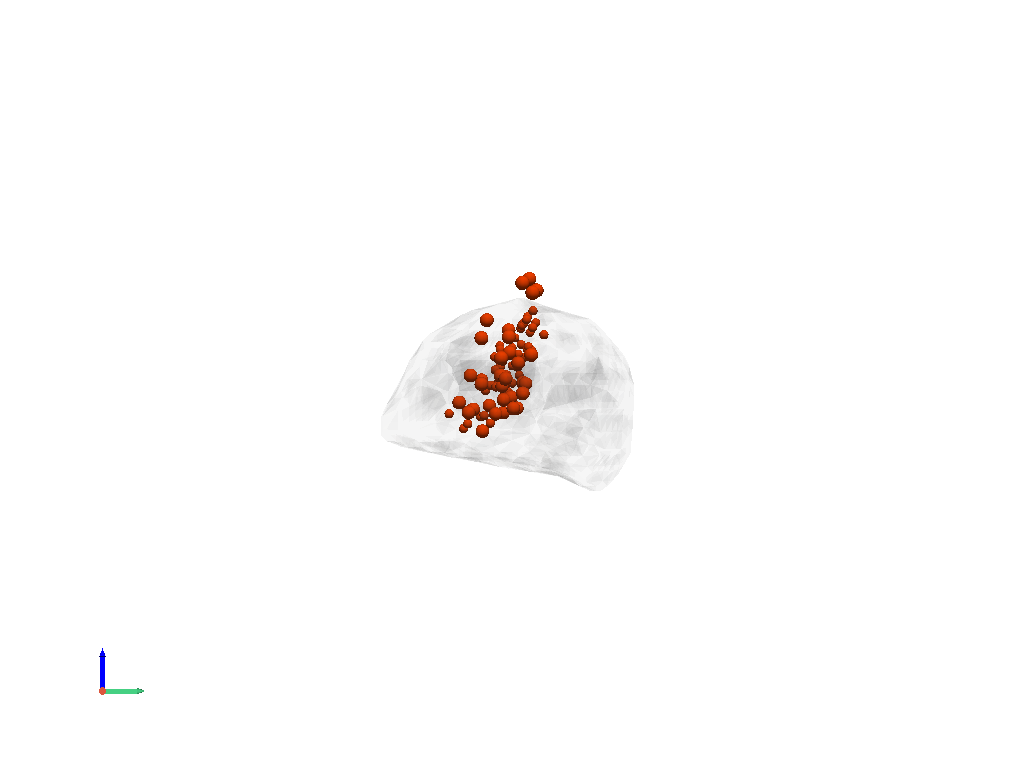

In [21]:
plotter = pv.Plotter()

# Plot the cortex mesh with the corresponding scalars and alpha values
plotter.add_mesh(STN_mesh["right_hemisphere"], color='dimgray', opacity=0.025, specular=5, specular_power=50)
plotter.background_color = "white"
plotter.add_axes(line_width=5, labels_off=True)

for index, contact in MNI_LFP_channels.iterrows():
    plotter.add_mesh(pv.Sphere(radius=0.25, center=[contact.x, contact.y, contact.z]), color="orangered", smooth_shading=True)
    
plotter.view_yz()
plotter.show(jupyter_backend='trame')